In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 1

# 関数・ユーティリティ

In [2]:
def show_plot(coef, value, coef_expected = None, value_expected = None, suptitle=None):
    # Plot signal and result
    
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(coef, label='original')
    if coef_expected is not None:
        plt.plot(coef_expected, label='expected')    
    plt.title('coeficients')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(value, label='original')
    if value_expected is not None:
        plt.plot(value_expected, label='expected')        
    
    plt.title('value')
    plt.legend()
    plt.grid()
    
    if suptitle is not None:
        plt.suptitle(suptitle)    

    plt.tight_layout()    
    if suptitle is not None:
        plt.subplots_adjust(top=0.85)

# 線形回帰でのスパースモデリング

## 観測情報 y と入力特徴量 x の準備

In [3]:
# シードの設定
np.random.seed(0)

# 特徴量とサンプルサイズ
n_features = 1000
n_samples = 100
n_nonzero_coefs = 20
n_iter = 1000

# 正則化パラメータ
alpha = 0.5

In [4]:
# 真の重みの生成

idx = np.random.randint(0, n_features, n_nonzero_coefs)
w = np.zeros(n_features)
w[idx] = np.random.normal(0.0, 1.0, n_nonzero_coefs)

In [5]:
# 入力データと観測情報

X = np.random.normal(0.0, 1.0, (n_samples, n_features))
y = X.dot(w) + np.random.normal(0.0, 1.0, n_samples)

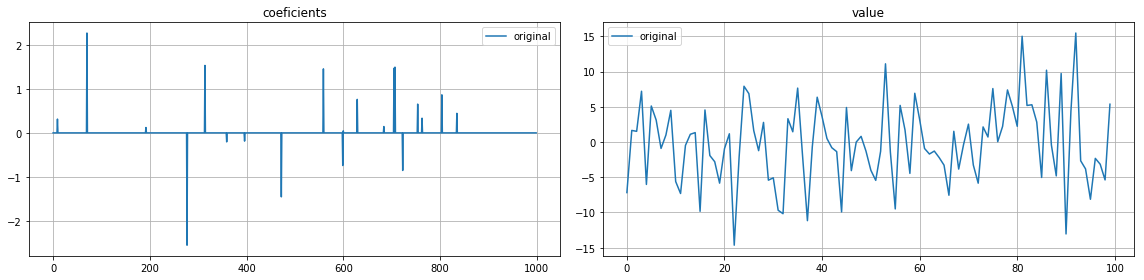

In [6]:
show_plot(w, y)

## sklearn の LASSO 実装

In [7]:
%%time
from sklearn.linear_model import Lasso

model = Lasso(alpha=alpha, max_iter=n_iter).fit(X, y)
w_ = model.coef_
p_ = model.predict(X)

CPU times: user 180 ms, sys: 90 ms, total: 270 ms
Wall time: 151 ms


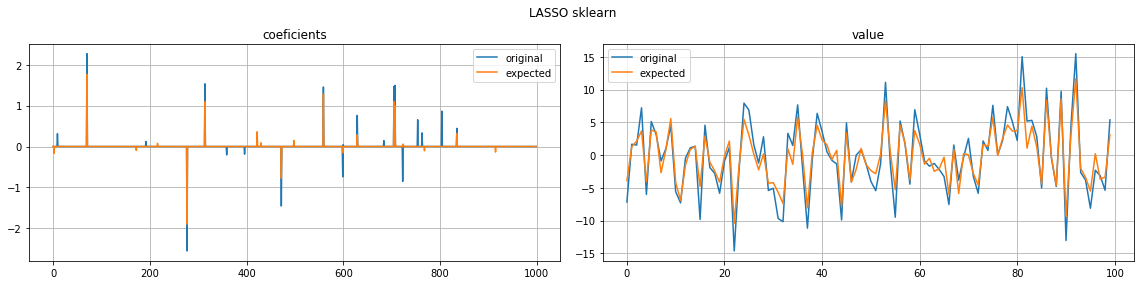

In [8]:
show_plot(w, y, w_, p_, 'LASSO sklearn')

In [9]:
len(np.where(w_ == 0)[0])

979

## 座標降下法

In [10]:
def soft_threshold(X, thresh):
    return np.where(np.abs(X) <= thresh, 0, X - thresh * np.sign(X))

In [11]:
%time

from copy import deepcopy

w_cd = np.zeros(n_features)

for _ in range(n_iter):
    for j in range(n_features):
        w_j = deepcopy(w_cd)
        w_j[j] = 0.0
        r_j = y - np.dot(X, w_j)
        w_cd[j] = soft_threshold(np.dot(X[:, j], r_j) / n_samples, alpha)        

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 34.8 µs


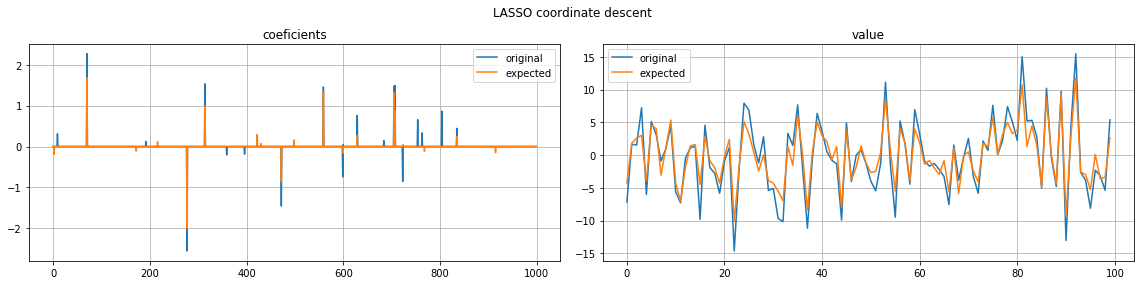

In [12]:
show_plot(w, y, w_cd, np.dot(X, w_cd), 'LASSO coordinate descent')

In [13]:
len(np.where(w_cd == 0)[0])

981